In [15]:
# Imports

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
import os
import shutil
import gpt
from PIL import Image
import cv2
import threading

In [16]:
# Open Image

DIRECTORY = "../images/"
IMAGE_NAME = "recipe2.jpg"
IMAGE_PATH = DIRECTORY + IMAGE_NAME

image = Image.open(IMAGE_PATH).convert('RGB')

In [17]:
# Process Image for easier reading

# Convert PIL Image to OpenCV format
img = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Reduce noise
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Inprove Contrast
_, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Median blur to remove remaining spots
denoised = cv2.medianBlur(thresh, 3)

# More smoothing
denoised = cv2.GaussianBlur(denoised, (3, 3), 0)

# Convert back to RGB (but still grayscale)
denoised_3channel = cv2.cvtColor(denoised, cv2.COLOR_GRAY2BGR)
denoised_rgb = cv2.cvtColor(denoised_3channel, cv2.COLOR_BGR2RGB)

# Convert to PIL Image and then to numpy array
processed_pil = Image.fromarray(denoised_rgb)
img_arr = np.array(processed_pil, dtype=np.uint32)
original_img_arr = np.array(processed_pil, dtype=np.uint8)

Text(0.5, 1.0, 'Original Image')

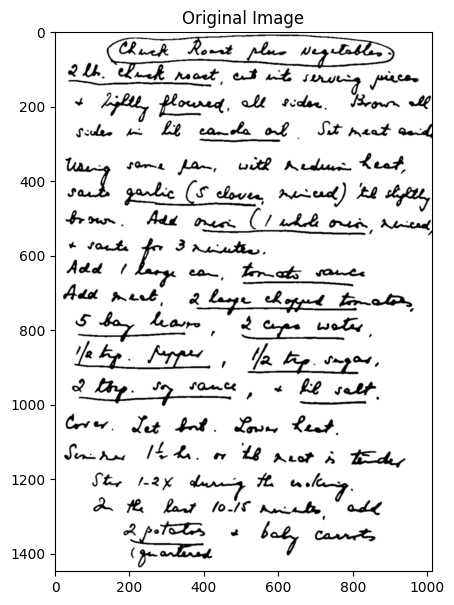

In [18]:
plt.figure(figsize=(15, 7))  # Adjust figure size as needed

#Show Images
plt.subplot(1, 2, 1)  # (rows, columns, index)
plt.imshow(np.array(original_img_arr))
#plt.axis('off')
plt.title("Original Image")

In [19]:
def process_image(img_arr):
    '''
    Detect colums in text, then split into segments where best fit
    '''

    # Calculate column brightness
    _, width, _ = img_arr.shape
    column_brightness = []
    
    # Calculate average brightness for each column
    for col_idx in range(width):
        col = img_arr[:, col_idx]
        R = np.mean(col[:, 0])
        G = np.mean(col[:, 1])
        B = np.mean(col[:, 2])
        avg = (R + G + B) / 3
        column_brightness.append(avg)
    
    # Find column splits
    column_brightness_np = np.array(column_brightness)
    smoothed_column_data = gaussian_filter1d(column_brightness_np, sigma=30)
    column_peaks, _ = find_peaks(smoothed_column_data,
        distance=100,
        prominence=32
    )
    
    # Split column into sections
    split_images = []
    column_sections = []
    start_col = 0
    all_row_peaks = [] #All peaks in brightness
    
    # Keep track of every place to split into columns
    all_column_splits = np.sort(np.append(column_peaks, width))
    
    # First split into columns
    for end_col in all_column_splits:
        column_section = img_arr[:, start_col:end_col]
        column_sections.append(column_section)
        start_col = end_col
    
    # Process EACH column section for rows
    for col_section in column_sections:
        # Calculate row brightness
        row_brightness = []
        for row in col_section:
            avg = np.mean(row)
            row_brightness.append(avg)
        
        # Find row splits
        row_brightness_np = np.array(row_brightness)
        smoothed_row_data = gaussian_filter1d(row_brightness_np, sigma=5)
        row_peaks, _ = find_peaks(smoothed_row_data,
            distance=200,
            prominence=32
        )
        all_row_peaks.append(row_peaks)
        
        # Split this column into rows
        start_row = 0
        
        # Add row peaks and the last row index
        all_row_splits = np.sort(np.append(row_peaks, col_section.shape[0]))
        
        # Process each row section
        for i, end_row in enumerate(all_row_splits):
            section = col_section[start_row:end_row]
            split_images.append(np.array(section).astype(np.uint8))
            start_row = end_row
    
    # Visualize the splits
    lined_img_arr = img_arr.copy()
    
    # vertical lines for column splits
    for col in column_peaks:
        lined_img_arr[:, col] = [0, 0, 255]
    
    # Add horizontal lines for row splits in each column section
    start_col = 0
    for i, end_col in enumerate(all_column_splits):
        row_peaks = all_row_peaks[i]
        # horizontal lines for this column section
        for row in row_peaks:
            lined_img_arr[row, start_col:end_col] = [255, 0, 0]
        start_col = end_col
    

    # Create figure
    fig, axs = plt.subplots(3, 1, figsize=(15, 20), gridspec_kw={'height_ratios': [1, 1, 2]})

    # column analysis
    axs[0].plot(smoothed_column_data, label="Smoothed Column Brightness")
    axs[0].plot(column_peaks, smoothed_column_data[column_peaks], "x", label="Column Splits")
    axs[0].set_xlabel("Pixel Column Index")
    axs[0].set_ylabel("Brightness")
    axs[0].legend()

    # Row analysis
    axs[1].plot(smoothed_row_data, label="Smoothed Row Brightness")
    axs[1].plot(row_peaks, smoothed_row_data[row_peaks], "x", label="Row Splits")
    axs[1].set_xlabel("Pixel Row Index")
    axs[1].set_ylabel("Brightness")
    axs[1].legend()

    # Result Splits
    axs[2].imshow(lined_img_arr)
    axs[2].set_title("Split Visualization (Blue: Columns, Red: Rows)")

    # Adjust layout to fit 100% horizontally
    plt.tight_layout()
    plt.show()

    
    return split_images

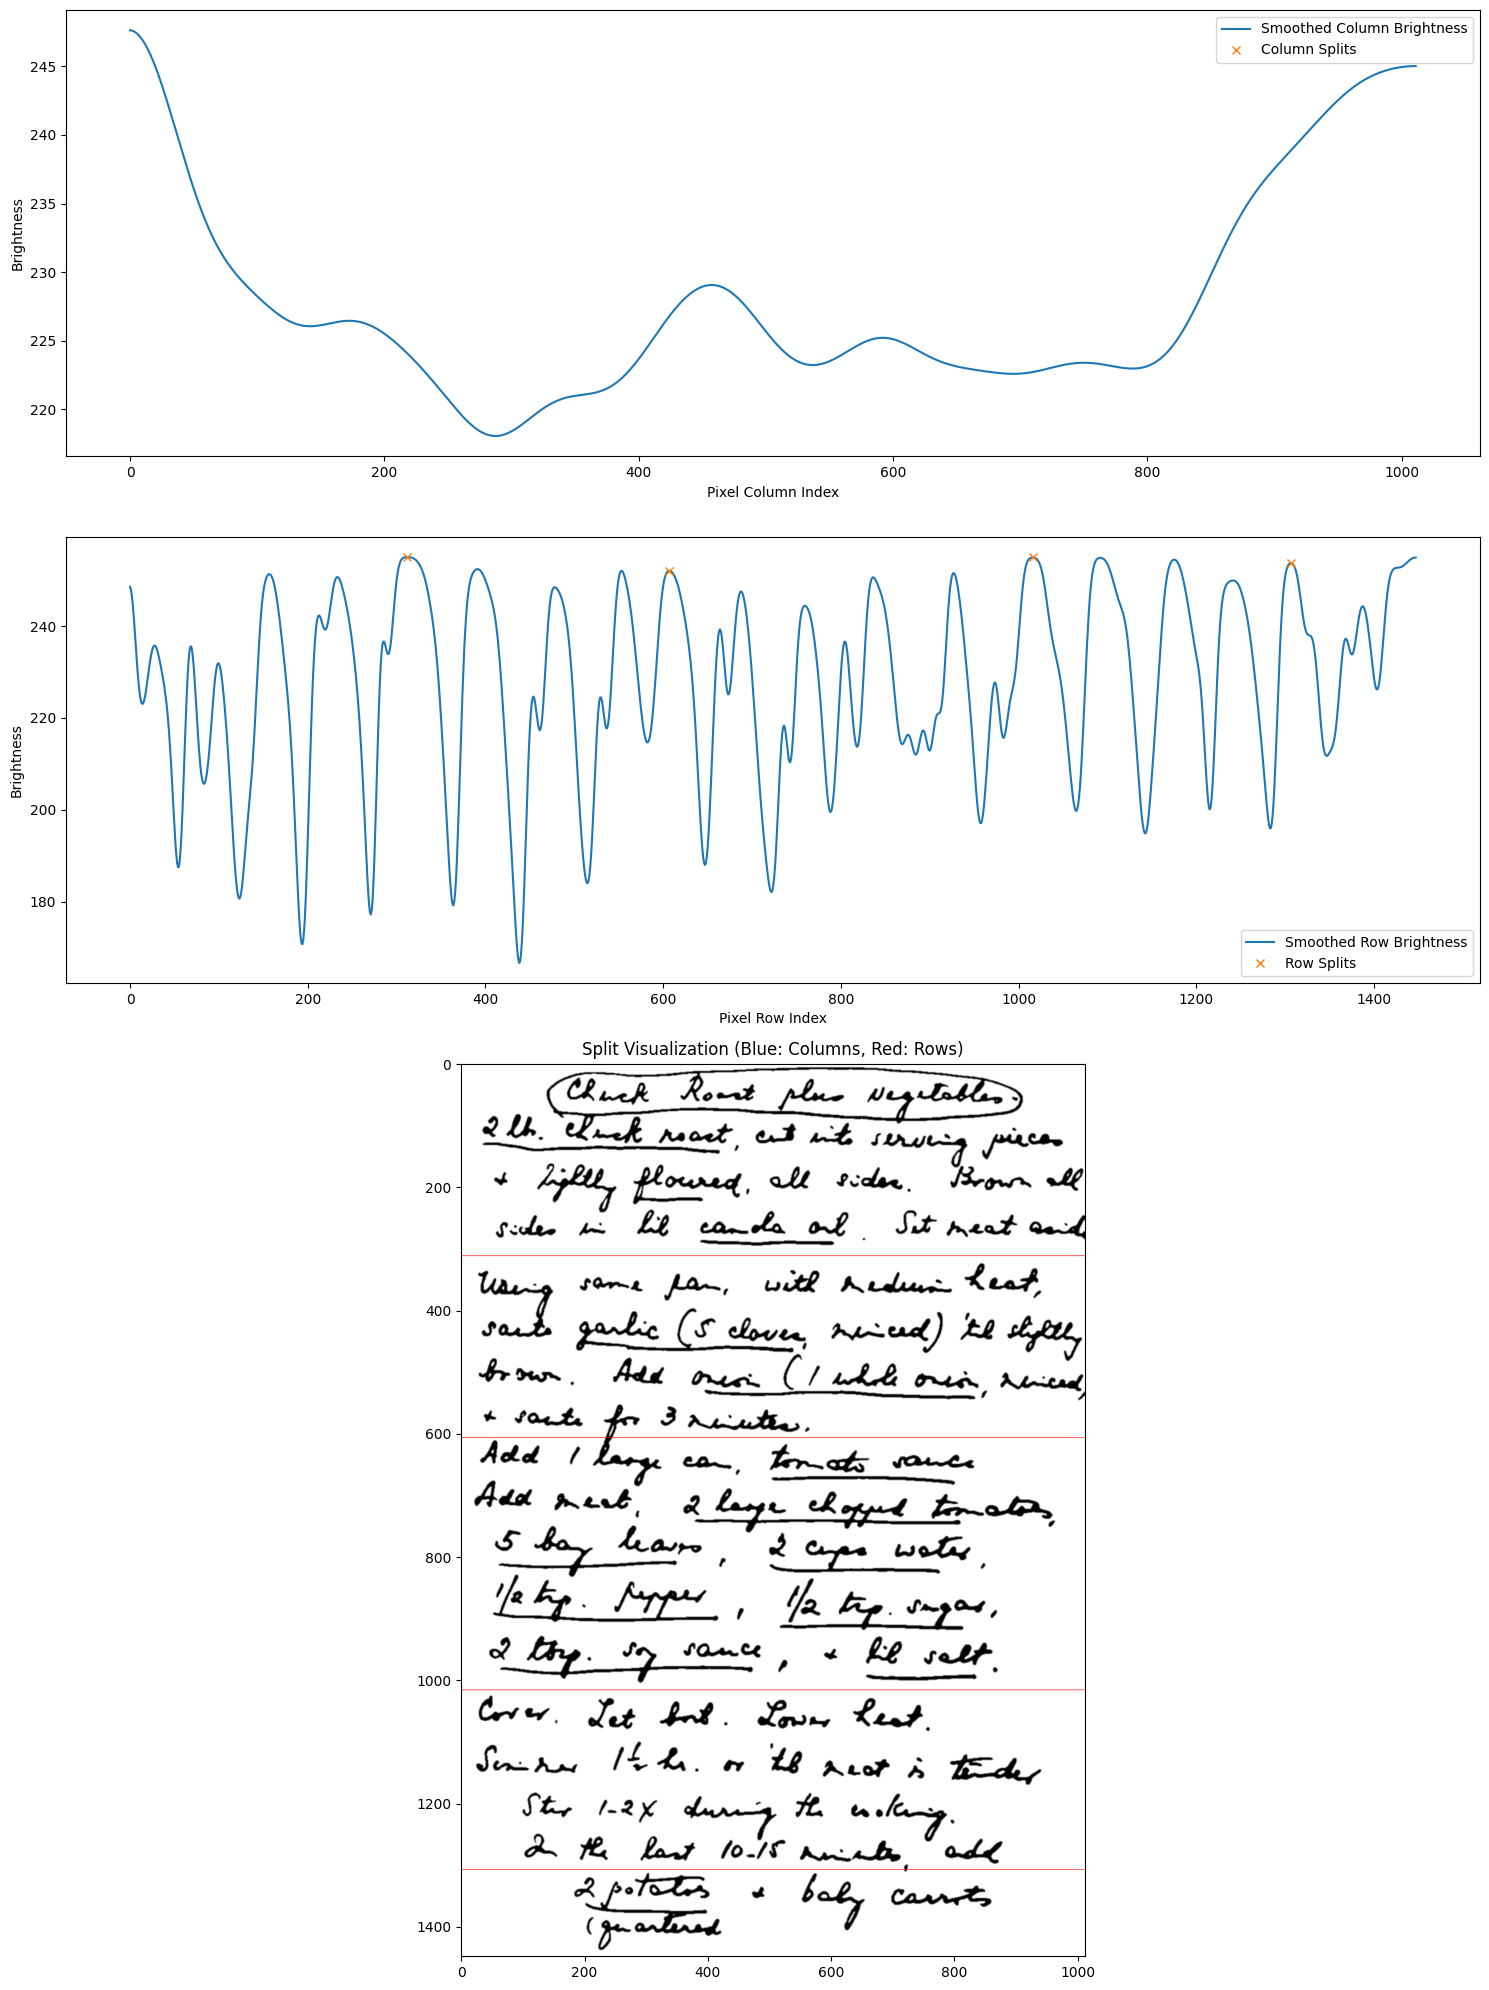

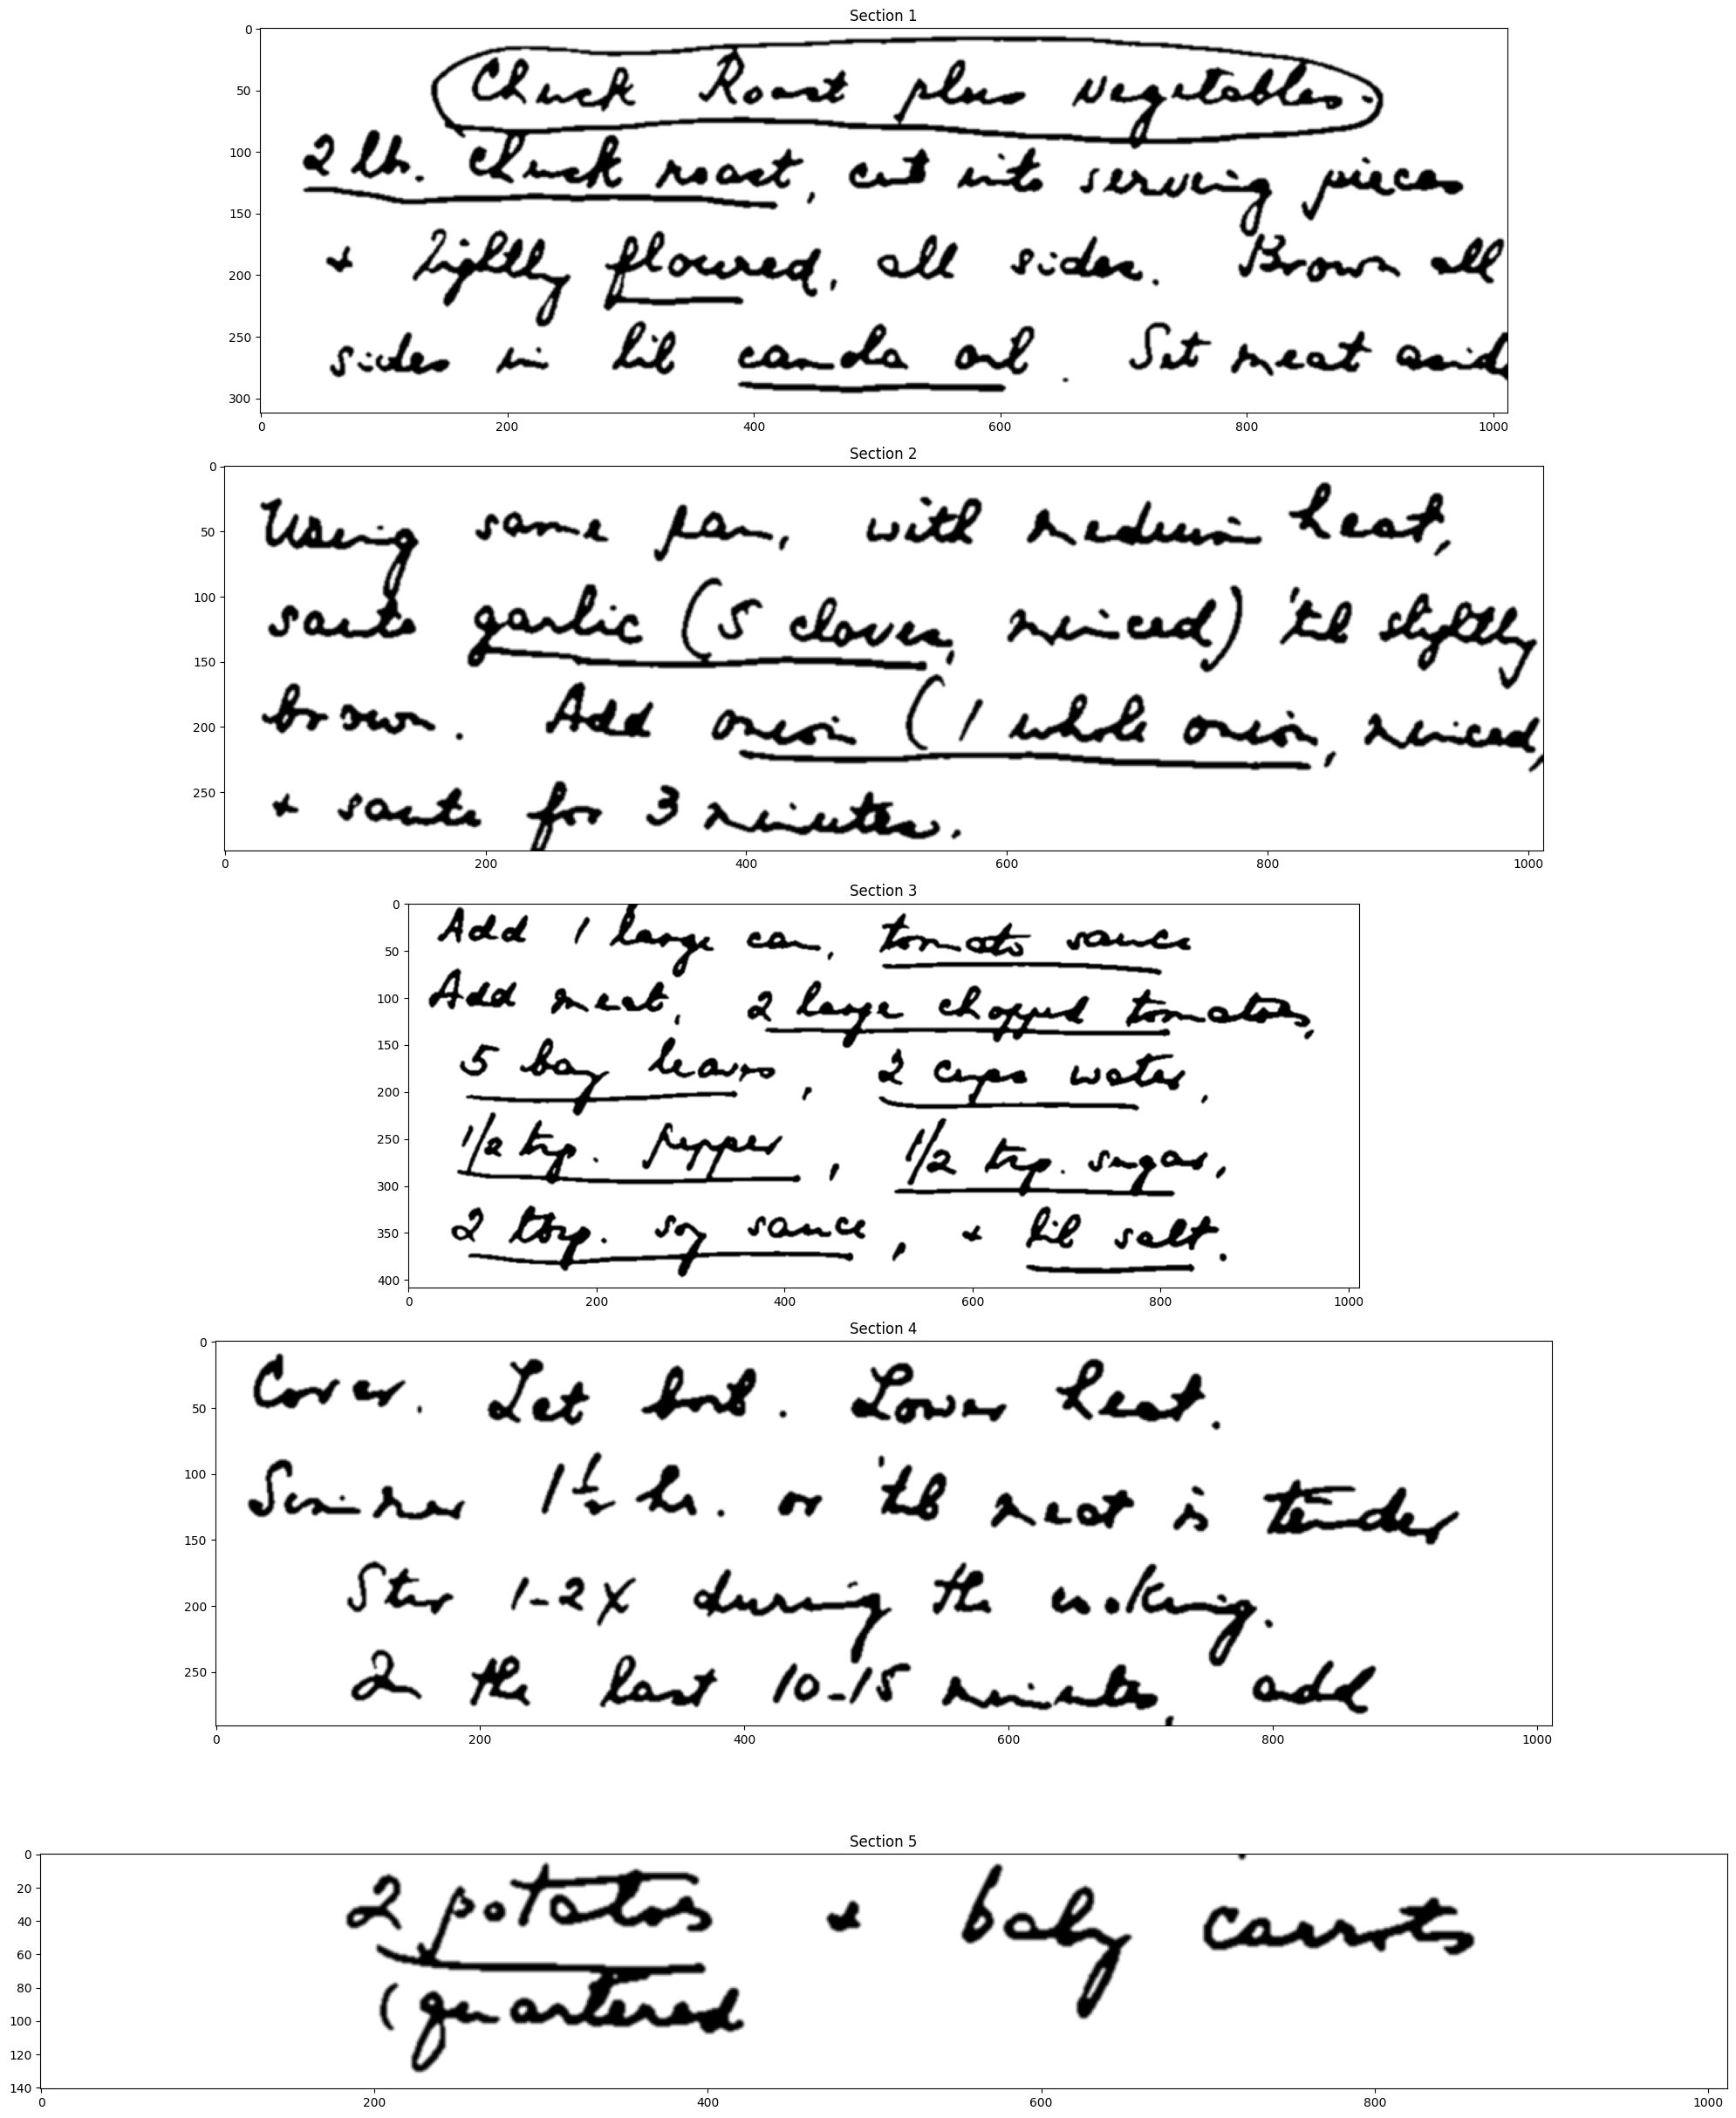

In [20]:
# Process the image
split_images = process_image(original_img_arr)

# Display all sections in a grid
num_sections = len(split_images)
num_cols = 1
num_rows = (num_sections + num_cols - 1) // num_cols

plt.figure(figsize=(20, 5 * num_rows))
for i, section in enumerate(split_images):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(section)
    plt.title(f"Section {i+1}")
plt.tight_layout()
plt.show()

Processing Image 0
Processing Image 1
Processing Image 2
Processing Image 3
Processing Image 4


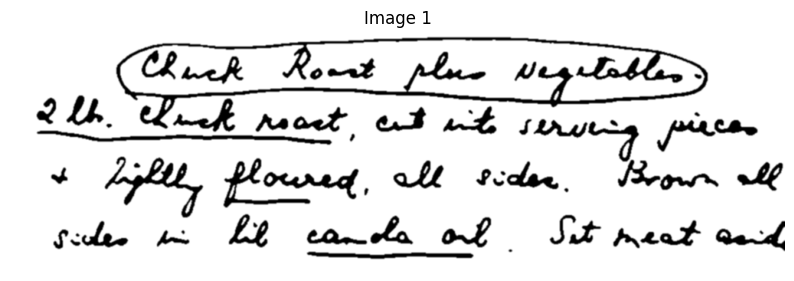

[T1-W1] C h u c k  90%  
[T1-W2] R o a s t  92%  
[T1-W3] p l u s  88%  
[T1-W4] V e g e t a b l e s  85%  

[B-L1-W1] 2  95%  
[B-L1-W2] l b .  93%  
[B-L1-W3] C h u c k  90%  
[B-L1-W4] r o a s t ,  88%  
[B-L1-W5] c u t  92%  
[B-L1-W6] i n t o  90%  
[B-L1-W7] s e r v i n g  85%  
[B-L1-W8] p i e c e s  88%  

[B-L2-W1] &  95%  
[B-L2-W2] l i g h t l y  85%  
[B-L2-W3] f l o u r e d ,  88%  
[B-L2-W4] a l l  92%  
[B-L2-W5] s i d e s .  88%  
[B-L2-W6] B r o w n  85%  
[B-L2-W7] a l l  90%  
[B-L2-W8] s i d e s  92%  
[B-L2-W9] i n  90%  
[B-L2-W10] h o t  85%  
[B-L2-W11] c a n o l a  88%  
[B-L2-W12] o i l .  92%  
[B-L2-W13] S e t  90%  
[B-L2-W14] m e a t  85%  
[B-L2-W15] a s i d e  88%  


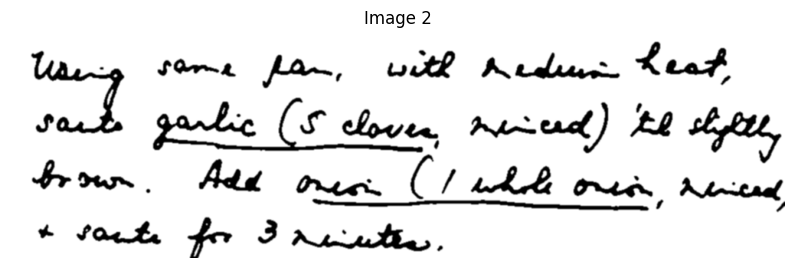

[B-L1-W1] U s i n g  85%  
[B-L1-W2] s a m e  88%  
[B-L1-W3] p a n ,  90%  
[B-L1-W4] w i t h  92%  
[B-L1-W5] m e d i u m  87%  
[B-L1-W6] h e a t ,  90%  
[B-L2-W1] s a u t e  93%  
[B-L2-W2] g a r l i c  92%  
[B-L2-W3] (  95%  
[B-L2-W4] 5  95%  
[B-L2-W5] c l o v e s ,  90%  
[B-L2-W6] m i n c e d )  88%  
[B-L2-W7] ' t i l  85%  
[B-L2-W8] s l i g h t l y  90%  
[B-L2-W9] b r o w n .  92%  
[B-L3-W1] A d d  93%  
[B-L3-W2] o n i o n  92%  
[B-L3-W3] (  95%  
[B-L3-W4] 1  95%  
[B-L3-W5] w h o l e  87%  
[B-L3-W6] o n i o n ,  90%  
[B-L3-W7] m i n c e d , )  85%  
[B-L4-W1] &  90%  
[B-L4-W2] s a u t e  93%  
[B-L4-W3] f o r  92%  
[B-L4-W4] 3  95%  
[B-L4-W5] m i n u t e s .  88%  


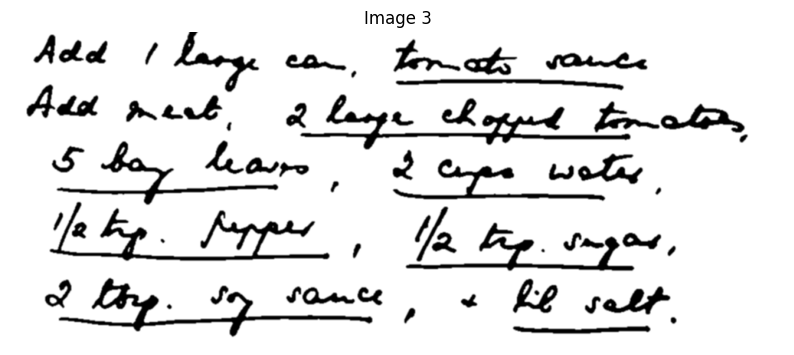

[B-L1-W1] A d d  90%  
[B-L1-W2] 1  92%  
[B-L1-W3] l a r g e  88%  
[B-L1-W4] c a n  90%  
[B-L1-W5] ,  95%  
[B-L1-W6] t o m a t o  85%  
[B-L1-W7] s a u c e  87%  
[B-L2-W1] A d d  90%  
[B-L2-W2] m e a t  88%  
[B-L2-W3] ,  95%  
[B-L2-W4] 2  92%  
[B-L2-W5] l a r g e  88%  
[B-L2-W6] c h o p p e d  85%  
[B-L2-W7] t o m a t o e s  87%  
[B-L2-W8] ,  95%  
[B-L3-W1] 5  92%  
[B-L3-W2] b a y  85%  
[B-L3-W3] l e a v e s  88%  
[B-L3-W4] ,  95%  
[B-L4-W1] 2  92%  
[B-L4-W2] c u p s  85%  
[B-L4-W3] w a t e r  87%  
[B-L4-W4] ,  95%  
[B-L5-W1] 1 / 2  92%  
[B-L5-W2] t s p .  85%  
[B-L5-W3] p e p p e r  80%  
[B-L5-W4] ,  95%  
[B-L6-W1] 1 / 2  92%  
[B-L6-W2] t s p .  85%  
[B-L6-W3] s u g a r  88%  
[B-L6-W4] ,  95%  
[B-L7-W1] 2  92%  
[B-L7-W2] t b s p .  85%  
[B-L7-W3] s o y  87%  
[B-L7-W4] s a u c e  88%  
[B-L7-W5] ,  95%  
[B-L7-W6] +  90%  
[B-L7-W7] l i l  80%  
[B-L7-W8] s a l t  85%  
[B-L7-W9] .  95%  


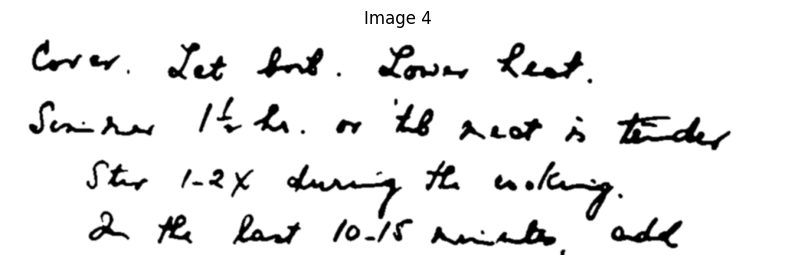

[B-L1-W1] C o v e r  90%  
[B-L1-W2] .  95%  
[B-L1-W3] L e t  88%  
[B-L1-W4] b o i l  85%  
[B-L1-W5] .  95%  
[B-L1-W6] L o w e r  90%  
[B-L1-W7] h e a t  92%  
[B-L1-W8] .  95%  

[B-L2-W1] S i m m e r  85%  
[B-L2-W2] 1 ½  88%  
[B-L2-W3] h r s  85%  
[B-L2-W4] .  95%  
[B-L2-W5] o r  78%  
[B-L2-W6] t i l  80%  
[B-L2-W7] m e a t  86%  
[B-L2-W8] i s  90%  
[B-L2-W9] t e n d e r  82%  

[B-L3-W1] S t i r  86%  
[B-L3-W2] 1 - 2 X  90%  
[B-L3-W3] d u r i n g  88%  
[B-L3-W4] t h e  92%  
[B-L3-W5] c o o k i n g  84%  
[B-L3-W6] .  95%  

[B-L4-W1] I n  90%  
[B-L4-W2] t h e  88%  
[B-L4-W3] l a s t  85%  
[B-L4-W4] 10 - 15  87%  
[B-L4-W5] m i n u t e s  82%  
[B-L4-W6] ,  95%  
[B-L4-W7] a d d  90%  


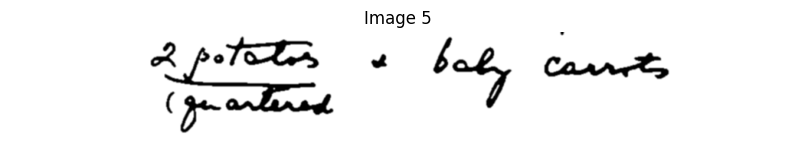

[B-L1-W1] 2 85%
[B-L1-W2] p o t a t o s 80%
[B-L1-W3] + 90%
[B-L1-W4] b a b y 85%
[B-L1-W5] c a r r o t s 83%
[B-L2-W1] ( 95%
[B-L2-W2] q u a r t e r e d 75%
[B-L2-W3] ) 95%


In [21]:
# Save and print all results

# Directory to save the split images
output_dir = "split_images"

# Clear the directory if it exists
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)  # Remove the directory and all its contents
os.makedirs(output_dir, exist_ok=True)  # Recreate the empty directory

responses = []
threads = []
num_threads = 5 

def readImage(responses, i, pic):
    converted_img = Image.fromarray(pic)
    
    # Save the image
    image_path = os.path.join(output_dir, f"image_{i+1}.webp")
    converted_img.save(image_path, 'WEBP', quality=15)
    
    #Get chatGPT translation
    import time
    time.sleep(.75*i)    # Pause 5.5 seconds
    print(f"Processing Image {i}")
    responses[i] = gpt.run_chatgpt(image_path)

responses = [None] * len(split_images)  # Initialize responses with size so it is thread safe
threads = []

# Start threads
for i, pic in enumerate(split_images):
    t = threading.Thread(target=readImage, args=(responses, i, pic))
    threads.append(t)
    t.start()

# Wait for all threads to finish
for t in threads:
    t.join()

# Display each image and its response in the original order
for i, pic in enumerate(split_images):
    plt.figure(figsize=(10, 10))
    plt.imshow(pic)
    plt.axis('off')
    plt.title(f"Image {i+1}")
    plt.show()
    print(responses[i])